In [7]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install required packages if not available
try:
    import seaborn as sns
    print("[OK] seaborn imported successfully")
except ImportError:
    print("[INSTALL] Installing seaborn...")
    !pip install seaborn
    import seaborn as sns

try:
    import tensorflow as tf
    print(f"[OK] TensorFlow {tf.__version__} imported successfully")
except ImportError:
    print("[INSTALL] Installing tensorflow...")
    !pip install tensorflow
    import tensorflow as tf

from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Bidirectional, Conv1D, 
    Dropout, Flatten, AveragePooling1D, MaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Attention mechanism - using TensorFlow built-in layers
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
print("[OK] Using TensorFlow built-in attention mechanism")

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    mean_absolute_percentage_error, r2_score
)
from sklearn.model_selection import train_test_split

print(f"[OK] All libraries imported successfully!")
print(f"[OK] TensorFlow version: {tf.__version__}")
print(f"[OK] Using GPU: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline
sns.set_style('whitegrid')

[OK] seaborn imported successfully
[OK] TensorFlow 2.18.0 imported successfully
[OK] Using TensorFlow built-in attention mechanism
[OK] All libraries imported successfully!
[OK] TensorFlow version: 2.18.0
[OK] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 1. Load Preprocessed Data

Tải dữ liệu đã được xử lý từ notebook `01_data_preprocessing.ipynb`

In [8]:
# Detect environment and set paths
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
IN_COLAB = 'google.colab' in sys.modules

if IN_KAGGLE:
    # Kaggle: Use input data from uploaded dataset
    data_dir = Path("/kaggle/input/processed")
    print(f"[KAGGLE] Loading from: {data_dir}")
elif IN_COLAB:
    # Colab: Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path("/content/drive/MyDrive/pm25-data/processed")
    print(f"[COLAB] Loading from Google Drive: {data_dir}")
else:
    # Local development
    data_dir = Path("../data/processed")
    print(f"[LOCAL] Loading from: {data_dir}")

# Check if data exists
if not data_dir.exists():
    print(f"[ERROR] Data directory not found: {data_dir}")
    print(f"[INFO] Please run 01_data_preprocessing.ipynb first to generate preprocessed data")
    sys.exit(1)
else:
    print(f"[SUCCESS] Data directory found: {data_dir}")

[KAGGLE] Loading from: /kaggle/input/processed
[SUCCESS] Data directory found: /kaggle/input/processed


In [9]:
# Load LSTM sequence data (24 timesteps) for fair comparison
print("[LOADING] Loading CNN1D-BiLSTM sequence data (24 timesteps)...")

try:
    # Load preprocessed sequence data
    cnn_train = pd.read_parquet(data_dir / 'lstm_sequences' / 'train')
    cnn_val = pd.read_parquet(data_dir / 'lstm_sequences' / 'val')
    cnn_test = pd.read_parquet(data_dir / 'lstm_sequences' / 'test')
    
    print(f"[SUCCESS] Data loaded successfully:")
    print(f"   Train: {cnn_train.shape}")
    print(f"   Val:   {cnn_val.shape}")
    print(f"   Test:  {cnn_test.shape}")
    
    # Load metadata
    with open(data_dir / 'feature_metadata.json', 'r') as f:
        feature_metadata = json.load(f)
    
    with open(data_dir / 'scaler_params.json', 'r') as f:
        scaler_params = json.load(f)
        
    print(f"[SUCCESS] Metadata loaded:")
    print(f"   Features: {len(feature_metadata['deep_learning_features'])}")
    print(f"   Target: {feature_metadata['target']}")
    
except FileNotFoundError as e:
    print(f"[ERROR] Required files not found: {e}")
    print(f"[INFO] Make sure to run the preprocessing notebook first")
    sys.exit(1)

[LOADING] Loading CNN1D-BiLSTM sequence data (24 timesteps)...
[SUCCESS] Data loaded successfully:
   Train: (201482, 21)
   Val:   (42725, 21)
   Test:  (42934, 21)
[SUCCESS] Metadata loaded:
   Features: 18
   Target: PM2_5_log_scaled


In [10]:
# Inspect the data structure
print("[INSPECT] Data structure analysis:")
print("-" * 50)

print("\n[COLUMNS] Available columns:")
for i, col in enumerate(cnn_train.columns):
    print(f"   {i+1:2d}. {col}")

print(f"\n[SEQUENCES] Sequence features:")
sequence_cols = [col for col in cnn_train.columns if col.endswith('_sequence')]
print(f"   Total: {len(sequence_cols)} sequence features")

# Show first few sequence feature names
for col in sequence_cols[:5]:
    print(f"   - {col}")
if len(sequence_cols) > 5:
    print(f"   ... and {len(sequence_cols) - 5} more")

print(f"\n[TARGET] Target variable: target_value")
print(f"   Values range: [{cnn_train['target_value'].min():.4f}, {cnn_train['target_value'].max():.4f}]")

print(f"\n[METADATA] Sequence characteristics:")
# Check sequence length by examining one sequence
sample_sequence = cnn_train[sequence_cols[0]].iloc[0]
sequence_length = len(sample_sequence)
n_features = len(sequence_cols)

print(f"   Sequence length: {sequence_length} timesteps")
print(f"   Number of features: {n_features}")
print(f"   Input shape will be: (batch_size, {sequence_length}, {n_features})")
print(f"   Note: Using 24 timesteps for fair comparison with LSTM and XGBoost models")

[INSPECT] Data structure analysis:
--------------------------------------------------

[COLUMNS] Available columns:
    1. location_id
    2. datetime
    3. PM10_scaled_sequence
    4. NO2_scaled_sequence
    5. SO2_scaled_sequence
    6. temperature_2m_scaled_sequence
    7. relative_humidity_2m_scaled_sequence
    8. wind_speed_10m_scaled_sequence
    9. surface_pressure_scaled_sequence
   10. precipitation_scaled_sequence
   11. hour_sin_sequence
   12. hour_cos_sequence
   13. month_sin_sequence
   14. month_cos_sequence
   15. day_of_week_sin_sequence
   16. day_of_week_cos_sequence
   17. wind_direction_sin_sequence
   18. wind_direction_cos_sequence
   19. is_weekend_sequence
   20. PM2_5_log_scaled_sequence
   21. target_value

[SEQUENCES] Sequence features:
   Total: 18 sequence features
   - PM10_scaled_sequence
   - NO2_scaled_sequence
   - SO2_scaled_sequence
   - temperature_2m_scaled_sequence
   - relative_humidity_2m_scaled_sequence
   ... and 13 more

[TARGET] Target v

## 2. Prepare Data for Deep Learning

Chuyển đổi dữ liệu Pandas thành numpy arrays phù hợp cho Keras/TensorFlow

In [11]:
def prepare_sequence_data(df, sequence_cols, target_col='target_value'):
    """
    Convert pandas DataFrame with sequence columns to numpy arrays
    
    Args:
        df: DataFrame with sequence columns (arrays in each cell)
        sequence_cols: List of sequence column names
        target_col: Target column name
    
    Returns:
        X: numpy array of shape (samples, timesteps, features)
        y: numpy array of shape (samples,)
    """
    print(f"   Converting {len(df)} samples...")
    
    # Extract sequences
    X = np.array([
        np.stack([df[col].iloc[i] for col in sequence_cols], axis=0)
        for i in range(len(df))
    ])
    
    # Transpose to (samples, timesteps, features) for Keras
    X = X.transpose(0, 2, 1)
    
    # Extract target values
    y = df[target_col].values
    
    print(f"   X shape: {X.shape} (samples, timesteps, features)")
    print(f"   y shape: {y.shape}")
    
    return X, y

print("[PROCESSING] Converting sequence data to numpy arrays...")

# Convert training data
print("\n[TRAIN] Training data:")
X_train, y_train = prepare_sequence_data(cnn_train, sequence_cols)

# Convert validation data
print("\n[VAL] Validation data:")
X_val, y_val = prepare_sequence_data(cnn_val, sequence_cols)

# Convert test data
print("\n[TEST] Test data:")
X_test, y_test = prepare_sequence_data(cnn_test, sequence_cols)

print(f"\n[SUCCESS] Data preparation completed!")
print(f"   Total training samples: {len(X_train):,}")
print(f"   Total validation samples: {len(X_val):,}")
print(f"   Total test samples: {len(X_test):,}")
print(f"   Input shape: {X_train.shape}")
print(f"   Target range: [{y_train.min():.4f}, {y_train.max():.4f}]")

[PROCESSING] Converting sequence data to numpy arrays...

[TRAIN] Training data:
   Converting 201482 samples...
   X shape: (201482, 24, 18) (samples, timesteps, features)
   y shape: (201482,)

[VAL] Validation data:
   Converting 42725 samples...
   X shape: (42725, 24, 18) (samples, timesteps, features)
   y shape: (42725,)

[TEST] Test data:
   Converting 42934 samples...
   X shape: (42934, 24, 18) (samples, timesteps, features)
   y shape: (42934,)

[SUCCESS] Data preparation completed!
   Total training samples: 201,482
   Total validation samples: 42,725
   Total test samples: 42,934
   Input shape: (201482, 24, 18)
   Target range: [0.0000, 1.0000]


In [12]:
# Data quality checks
print("[QUALITY] Data quality verification:")
print("-" * 50)

# Check for NaN values
print(f"\n[NAN] NaN values check:")
print(f"   X_train NaN: {np.isnan(X_train).sum()}")
print(f"   y_train NaN: {np.isnan(y_train).sum()}")
print(f"   X_val NaN: {np.isnan(X_val).sum()}")
print(f"   y_val NaN: {np.isnan(y_val).sum()}")

# Check data ranges
print(f"\n[RANGES] Data ranges:")
print(f"   X_train: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"   X_val: [{X_val.min():.4f}, {X_val.max():.4f}]")
print(f"   y_train: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"   y_val: [{y_val.min():.4f}, {y_val.max():.4f}]")

# Check for infinite values
print(f"\n[INF] Infinite values check:")
print(f"   X_train inf: {np.isinf(X_train).sum()}")
print(f"   y_train inf: {np.isinf(y_train).sum()}")

if (np.isnan(X_train).sum() == 0 and np.isnan(y_train).sum() == 0 and 
    np.isinf(X_train).sum() == 0 and np.isinf(y_train).sum() == 0):
    print(f"\n[SUCCESS] Data quality check passed - no NaN or infinite values!")
else:
    print(f"\n[ERROR] Data quality issues detected!")

[QUALITY] Data quality verification:
--------------------------------------------------

[NAN] NaN values check:
   X_train NaN: 0
   y_train NaN: 0
   X_val NaN: 0
   y_val NaN: 0

[RANGES] Data ranges:
   X_train: [-1.0000, 1.0000]
   X_val: [-1.0000, 1.0522]
   y_train: [0.0000, 1.0000]
   y_val: [0.0000, 0.9268]

[INF] Infinite values check:
   X_train inf: 0
   y_train inf: 0

[SUCCESS] Data quality check passed - no NaN or infinite values!


In [13]:
# Enhanced metrics calculation function - Safe version to avoid division by zero
def calculate_metrics_safe(y_true, y_pred, model_name="Model"):
    """Calculate and display regression metrics for PM2.5 prediction - Safe version"""
    
    # Calculate core metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Safe calculation of percentage-based metrics
    # Only use non-zero values to avoid division by zero
    non_zero_mask = np.abs(y_true) > 1e-3  # Values > 0.001
    
    if np.sum(non_zero_mask) > 10:  # Need at least 10 non-zero values
        # Calculate MAPE safely
        try:
            mape = mean_absolute_percentage_error(y_true[non_zero_mask], y_pred[non_zero_mask]) * 100
            mape = min(mape, 500.0)  # Cap at 500%
        except:
            mape = float('inf')
    else:
        mape = float('inf')
    
    # Print results with improved formatting
    print(f"\n[METRICS] {model_name} Performance:")
    print("-" * 60)
    print(f"   R²:   {r2:.6f}   (Coefficient of Determination)")
    print(f"   RMSE: {rmse:.6f}   (Root Mean Square Error)")  
    print(f"   MAE:  {mae:.6f}   (Mean Absolute Error)")
    print(f"   MSE:  {mse:.6f}   (Mean Squared Error)")
    
    if mape == float('inf'):
        print(f"   MAPE: N/A        (Cannot calculate - too many zero values)")
    else:
        print(f"   MAPE: {mape:.4f}%   (Mean Absolute Percentage Error)")
    
    print("-" * 60)
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape if mape != float('inf') else None,
        'mse': mse
    }

# Denormalization function for PM2.5 values (Updated for Log Transformation)
def denormalize_pm25(normalized_values, scaler_params):
    """
    Denormalize PM2.5 values to original scale
    
    IMPORTANT: If log transformation was applied during preprocessing:
    1. First denormalize: scaled -> log(1 + PM2.5)
    2. Then inverse log: expm1 -> PM2.5
    
    Auto-detect: Check if 'PM2_5_log' exists in scaler_params
    """
    # Auto-detect if log transformation was applied
    # If 'PM2_5_log' exists, it means log transform was used
    if 'PM2_5_log' in scaler_params:
        # Log transformation was applied
        pm25_params = scaler_params['PM2_5_log']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Step 1: Denormalize to log scale
        log_values = normalized_values * (max_val - min_val) + min_val
        
        # Step 2: Inverse log transform: exp(x) - 1
        original_values = np.expm1(log_values)
        
        print(f"[DENORM] Applied inverse log transform (expm1) after denormalization")
        print(f"   Log scale range: [{log_values.min():.4f}, {log_values.max():.4f}]")
        print(f"   Original scale range: [{original_values.min():.2f}, {original_values.max():.2f}] μg/m³")
    
    elif 'PM2_5' in scaler_params:
        # Standard normalization (no log transform)
        pm25_params = scaler_params['PM2_5']
        min_val = pm25_params['min']
        max_val = pm25_params['max']
        
        # Reverse Min-Max normalization: original = normalized * (max - min) + min
        original_values = normalized_values * (max_val - min_val) + min_val
        
        print(f"[DENORM] Standard denormalization (no log transform)")
        print(f"   Original scale range: [{original_values.min():.2f}, {original_values.max():.2f}] μg/m³")
    
    else:
        raise ValueError("Cannot find PM2.5 scaling parameters. Check 'PM2_5' or 'PM2_5_log' in scaler_params")
    
    return original_values

def denormalize_pm25_simple(normalized_values, scaler_params):
    """
    Simple denormalization without inverse log (for comparison in normalized space)
    """
    pm25_params = scaler_params.get('PM2_5_log', scaler_params.get('PM2_5'))
    min_val = pm25_params['min']
    max_val = pm25_params['max']
    
    original_values = normalized_values * (max_val - min_val) + min_val
    return original_values

print("[FUNCTIONS] Metrics and utility functions defined!")
print("[INFO] denormalize_pm25() now supports log transformed targets")

[FUNCTIONS] Metrics and utility functions defined!
[INFO] denormalize_pm25() now supports log transformed targets


In [14]:
# Advanced data analysis to understand model limitations
def analyze_data_distribution(y_train, y_val, y_test):
    """Analyze the distribution of target values to understand potential issues"""
    
    print("[ANALYSIS] Data Distribution Analysis:")
    print("=" * 60)
    
    # Combine all data for analysis
    all_data = np.concatenate([y_train, y_val, y_test])
    
    # Calculate percentiles
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    values = np.percentile(all_data, percentiles)
    
    print(f"\n[PERCENTILES] Target value distribution:")
    for p, v in zip(percentiles, values):
        print(f"   {p:2d}th percentile: {v:.4f}")
    
    # Check for extreme values
    q1, q3 = np.percentile(all_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (all_data < lower_bound) | (all_data > upper_bound)
    outlier_count = np.sum(outliers)
    
    print(f"\n[OUTLIERS] Outlier analysis:")
    print(f"   IQR: {iqr:.4f}")
    print(f"   Lower bound: {lower_bound:.4f}")
    print(f"   Upper bound: {upper_bound:.4f}")
    print(f"   Outliers: {outlier_count:,} ({outlier_count/len(all_data)*100:.2f}%)")
    
    # Check data balance
    zero_near_count = np.sum(all_data < 0.01)
    high_value_count = np.sum(all_data > 0.8)
    
    print(f"\n[BALANCE] Data balance check:")
    print(f"   Near-zero values (< 0.01): {zero_near_count:,} ({zero_near_count/len(all_data)*100:.2f}%)")
    print(f"   High values (> 0.8): {high_value_count:,} ({high_value_count/len(all_data)*100:.2f}%)")
    
    # Recommendations
    print(f"\n[RECOMMENDATIONS] Based on data analysis:")
    
    if outlier_count > len(all_data) * 0.05:
        print(f" High outlier ratio ({outlier_count/len(all_data)*100:.1f}%) - consider robust scaling")
    
    if zero_near_count > len(all_data) * 0.1:
        print(f" Many near-zero values - may cause MAPE issues")
    
    if high_value_count < len(all_data) * 0.01:
        print(f" Few high values - model may struggle with extreme predictions")
        
    return {
        'percentiles': dict(zip(percentiles, values)),
        'outlier_ratio': outlier_count/len(all_data),
        'zero_ratio': zero_near_count/len(all_data),
        'high_ratio': high_value_count/len(all_data)
    }

# Run the analysis
data_stats = analyze_data_distribution(y_train, y_val, y_test)

# Enhanced data preprocessing suggestions
print(f"\n[SUGGESTIONS] Model improvement suggestions:")
print(f"   1. Use robust scaling (quantile-based) instead of min-max")
print(f"   2. Implement weighted loss function for extreme values")
print(f"   3. Consider ensemble methods (multiple models)")
print(f"   4. Add temporal features (hour, day, season)")
print(f"   5. Location-specific normalization")
print("=" * 60)

[ANALYSIS] Data Distribution Analysis:

[PERCENTILES] Target value distribution:
    1th percentile: 0.1540
    5th percentile: 0.2804
   10th percentile: 0.3400
   25th percentile: 0.4293
   50th percentile: 0.5197
   75th percentile: 0.6021
   90th percentile: 0.6690
   95th percentile: 0.7081
   99th percentile: 0.7749

[OUTLIERS] Outlier analysis:
   IQR: 0.1728
   Lower bound: 0.1700
   Upper bound: 0.8614
   Outliers: 3,678 (1.28%)

[BALANCE] Data balance check:
   Near-zero values (< 0.01): 75 (0.03%)
   High values (> 0.8): 1,575 (0.55%)

[RECOMMENDATIONS] Based on data analysis:
 Few high values - model may struggle with extreme predictions

[SUGGESTIONS] Model improvement suggestions:
   1. Use robust scaling (quantile-based) instead of min-max
   2. Implement weighted loss function for extreme values
   3. Consider ensemble methods (multiple models)
   4. Add temporal features (hour, day, season)
   5. Location-specific normalization


## 3. Build CNN1D + BiLSTM + Attention Model

Tạo mô hình theo kiến trúc đề xuất trong đề tài

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, 
    Bidirectional, LSTM, Dropout, Dense,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_cnn_bilstm_attention_model(input_shape, 
                                     cnn_filters=[64, 128, 256],
                                     kernel_size=5,
                                     lstm_units=128,
                                     attention_heads=8,
                                     dropout_rate=0.2,
                                     learning_rate=0.0005):
    """
    Improved CNN1D -> BiLSTM -> Attention Model for PM2.5 Prediction
    
    STRICT ARCHITECTURE: CNN1D -> BiLSTM -> Attention
    
    KEY IMPROVEMENTS from analysis:
    1. Larger kernel size (5) to capture longer temporal patterns
    2. More CNN layers (3) with residual connections
    3. Increased LSTM units (128) for better representation
    4. More attention heads (8) for richer attention patterns
    5. Lower dropout (0.2) to prevent underfitting
    6. Lower learning rate (0.0005) for stability
    7. AMSGrad optimizer variant for better convergence
    8. Huber loss for robustness to outliers
    
    Args:
        input_shape: (timesteps, features) - e.g., (24, 17)
        cnn_filters: List of filter sizes [64, 128, 256]
        kernel_size: Kernel size for Conv1D (5 for longer patterns)
        lstm_units: Number of units in BiLSTM (128)
        attention_heads: Number of attention heads (8)
        dropout_rate: Dropout rate (0.2)
        learning_rate: Learning rate (0.0005)
    
    Returns:
        Compiled Keras model
    """
    
    print(f"\n{'='*70}")
    print(f"🚀 Building Improved CNN1D -> BiLSTM -> Attention Model")
    print(f"{'='*70}")
    print(f"📐 Configuration:")
    print(f"   • Input shape: {input_shape}")
    print(f"   • CNN filters: {cnn_filters}")
    print(f"   • Kernel size: {kernel_size} (larger for longer patterns)")
    print(f"   • LSTM units: {lstm_units}")
    print(f"   • Attention heads: {attention_heads}")
    print(f"   • Dropout rate: {dropout_rate}")
    print(f"   • Learning rate: {learning_rate}")
    print(f"{'='*70}\n")
    
    # ========================================
    # INPUT LAYER
    # ========================================
    inputs = Input(shape=input_shape, name='input')
    
    # ========================================
    # CNN1D BLOCKS với Residual Connections
    # ========================================
    x = inputs
    
    for i, filters in enumerate(cnn_filters):
        # Residual connection - project if needed
        if i == 0:
            residual = Conv1D(filters, 1, padding='same', name=f'residual_proj_{i}')(x)
        else:
            if x.shape[-1] != filters:
                residual = Conv1D(filters, 1, padding='same', name=f'residual_proj_{i}')(x)
            else:
                residual = x
        
        # CNN Block
        x = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same',
            name=f'conv1d_{i+1}'
        )(x)
        x = BatchNormalization(momentum=0.99, name=f'bn_conv_{i+1}')(x)
        x = Activation('relu', name=f'relu_conv_{i+1}')(x)
        
        # Add residual connection
        x = Add(name=f'add_conv_{i+1}')([x, residual])
        x = Dropout(dropout_rate * 0.5, name=f'dropout_conv_{i+1}')(x)
    
    # Layer normalization after CNN
    x = LayerNormalization(name='ln_after_cnn')(x)
    
    # ========================================
    # BIDIRECTIONAL LSTM
    # ========================================
    # Single powerful BiLSTM layer
    x = Bidirectional(
        LSTM(
            units=lstm_units,
            return_sequences=True,  # Must return sequences for attention
            dropout=dropout_rate,
            recurrent_dropout=0.0,  # Keep 0 for stability
            name='lstm'
        ),
        name='bilstm'
    )(x)
    
    # Layer normalization after BiLSTM
    x = LayerNormalization(name='ln_after_bilstm')(x)
    x = Dropout(dropout_rate, name='dropout_bilstm')(x)
    
    # ========================================
    # MULTI-HEAD ATTENTION
    # ========================================
    # Self-attention to focus on important timesteps
    attention_output = MultiHeadAttention(
        num_heads=attention_heads,
        key_dim=lstm_units * 2 // attention_heads,  # key_dim per head
        dropout=dropout_rate,
        name='multi_head_attention'
    )(x, x)  # Self-attention
    
    # Add & Normalize with residual connection
    x = Add(name='add_attention')([x, attention_output])
    x = LayerNormalization(name='ln_after_attention')(x)
    x = Dropout(dropout_rate, name='dropout_attention')(x)
    
    # ========================================
    # GLOBAL POOLING
    # ========================================
    # Aggregate temporal information
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    
    # ========================================
    # DENSE LAYERS
    # ========================================
    # Dense layer 1
    x = Dense(256, name='dense_1')(x)
    x = BatchNormalization(momentum=0.99, name='bn_dense_1')(x)
    x = Activation('relu', name='relu_dense_1')(x)
    x = Dropout(dropout_rate, name='dropout_dense_1')(x)
    
    # Dense layer 2
    x = Dense(128, name='dense_2')(x)
    x = BatchNormalization(momentum=0.99, name='bn_dense_2')(x)
    x = Activation('relu', name='relu_dense_2')(x)
    x = Dropout(dropout_rate, name='dropout_dense_2')(x)
    
    # Dense layer 3
    x = Dense(64, name='dense_3')(x)
    x = BatchNormalization(momentum=0.99, name='bn_dense_3')(x)
    x = Activation('relu', name='relu_dense_3')(x)
    x = Dropout(dropout_rate, name='dropout_dense_3')(x)
    
    # ========================================
    # OUTPUT LAYER
    # ========================================
    outputs = Dense(1, activation='linear', name='output')(x)
    
    # ========================================
    # CREATE MODEL
    # ========================================
    model = Model(inputs=inputs, outputs=outputs, name='CNN_BiLSTM_Attention_Improved')
    
    # ========================================
    # COMPILE MODEL
    # ========================================
    optimizer = Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True  # AMSGrad variant for better convergence
    )
    
    model.compile(
        optimizer=optimizer,
        loss='huber',  # Huber loss: robust to outliers
        metrics=['mae', 'mse']
    )
    
    return model

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

MODEL_PARAMS = {
    'cnn_filters': [64, 128, 256],    # 3 CNN layers with increasing filters
    'kernel_size': 5,                  # Larger kernel for longer patterns
    'lstm_units': 128,                 # More LSTM units
    'attention_heads': 8,              # More attention heads
    'dropout_rate': 0.2,               # Lower dropout to prevent underfitting
    'learning_rate': 0.0005            # Lower LR for stability
}

model = build_cnn_bilstm_attention_model(
    input_shape=INPUT_SHAPE,
    **MODEL_PARAMS
)

model.summary()


🚀 Building Improved CNN1D -> BiLSTM -> Attention Model
📐 Configuration:
   • Input shape: (24, 18)
   • CNN filters: [64, 128, 256]
   • Kernel size: 5 (larger for longer patterns)
   • LSTM units: 128
   • Attention heads: 8
   • Dropout rate: 0.2
   • Learning rate: 0.0005



I0000 00:00:1765342960.485127      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765342960.485686      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "CNN_BiLSTM_Attention_Improved"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 24, 18)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 64)    │      5,824 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_1           │ (None, 24, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_conv_1         │ (None, 24, 64)    │          0 │ bn_conv_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_proj_0     │ (None, 24, 64)    │      1,216 │ input[0][0]       │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_conv_1 (Add)    │ (None, 24, 64)    │          0 │ relu_conv_1[0][0… │
│                     │                   │            │ residual_proj_0[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_1      │ (None, 24, 64)    │          0 │ add_conv_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 128)   │     41,088 │ dropout_conv_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_2           │ (None, 24, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_conv_2         │ (None, 24, 128)   │          0 │ bn_conv_2[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_proj_1     │ (None, 24, 128)   │      8,320 │ dropout_conv_1[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_conv_2 (Add)    │ (None, 24, 128)   │          0 │ relu_conv_2[0][0… │
│                     │                   │            │ residual_proj_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_2      │ (None, 24, 128)   │          0 │ add_conv_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 256)   │    164,096 │ dropout_conv_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_3           │ (None, 24, 256)   │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_conv_3         │ (None, 24, 256)   │          0 │ bn_conv_3[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_proj_2     │ (None, 24, 256)   │     33,024 │ dropout_conv_2[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_conv_3 (Add)    │ (None, 24, 256)   │          0 │ relu_conv_3[0][0… │
│                     │                   │            │ residual_proj_2[

 Total params: 1,023,105 (3.90 MB)

 Trainable params: 1,021,313 (3.90 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 4. Train the Model

Huấn luyện mô hình với early stopping và learning rate scheduling

In [ ]:
def get_callbacks(model_path='best_pm25_model.keras', 
                 patience=20,
                 reduce_lr_patience=7,
                 min_delta=1e-5):
    """
    Improved training callbacks
    
    Args:
        model_path: Path to save best model
        patience: Patience for early stopping (increased to 20)
        reduce_lr_patience: Patience for reducing LR (7)
        min_delta: Minimum change to qualify as improvement
    
    Returns:
        List of callbacks
    """
    
    callbacks = [
        # Early stopping with higher patience
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            mode='min',
            min_delta=min_delta
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,        # Reduce by 30% (gentler than 50%)
            patience=reduce_lr_patience,
            min_lr=1e-7,
            verbose=1,
            mode='min',
            min_delta=min_delta
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
            mode='min'
        )
    ]
    
    return callbacks

TRAINING_CONFIG = {
    'epochs': 150,              # Reduced epochs (early stopping will handle it)
    'batch_size': 256,          # Larger batch for more stable gradients
    'verbose': 1
}

callbacks = get_callbacks(
    model_path='best_pm25_model.keras',
    patience=20,              # Higher patience
    reduce_lr_patience=7,     # Reduce LR patience
    min_delta=1e-5
)

# Start training
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    **TRAINING_CONFIG
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n[COMPLETED] Training completed!")
print(f"   Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"   Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")

Epoch 1/150


I0000 00:00:1765342973.050835     243 cuda_dnn.cc:529] Loaded cuDNN version 90300


788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1998 - mae: 0.4460 - mse: 0.4892
Epoch 1: val_loss improved from inf to 0.00901, saving model to best_pm25_model.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.1996 - mae: 0.4458 - mse: 0.4888 - val_loss: 0.0090 - val_mae: 0.0923 - val_mse: 0.0180 - learning_rate: 5.0000e-04
Epoch 2/150
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0140 - mae: 0.1183 - mse: 0.0294
Epoch 2: val_loss improved from 0.00901 to 0.00380, saving model to best_pm25_model.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.0140 - mae: 0.1183 - mse: 0.0293 - val_loss: 0.0038 - val_mae: 0.0651 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 3/150
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0076 - mae: 0.0954 - mse: 0.0152
Epoch 3: val_loss improved from 0.00380 to 0.00240, saving model to best_pm25_model.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 0.0076 - mae: 0.0954 - mse: 0.0152 - val_loss: 0.0024 - val_mae: 0

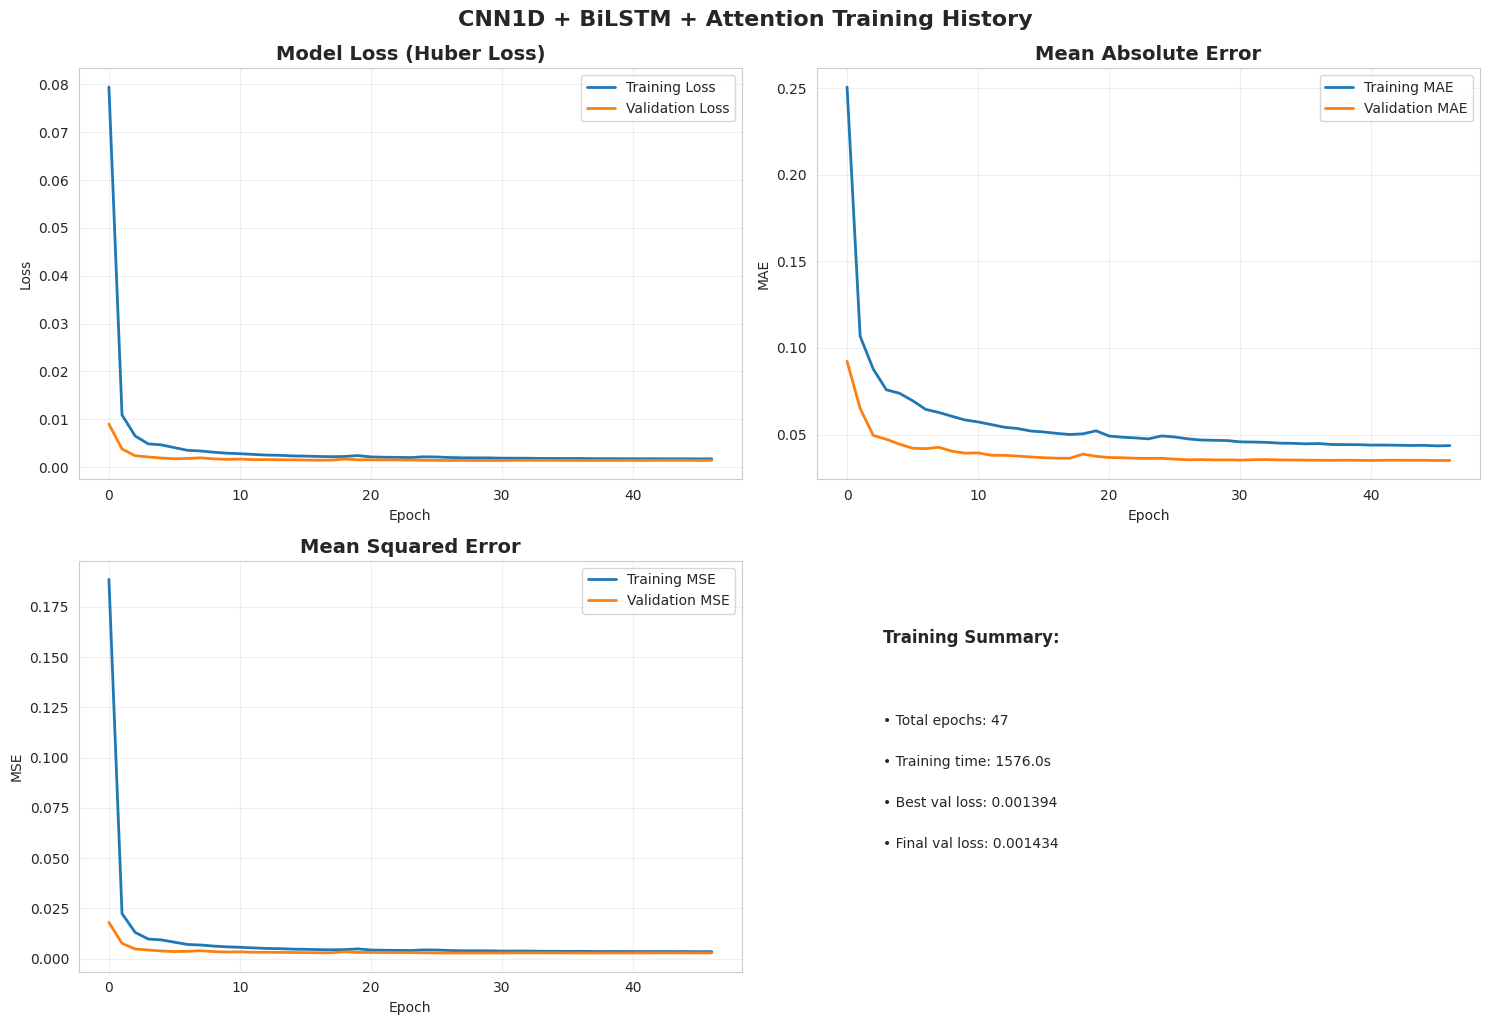


[SUMMARY] Training Summary:
   Total epochs run: 47
   Best epoch: 27
   Training time: 1576.0 seconds (26.27 minutes)
   Average time per epoch: 33.5 seconds


In [17]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss (Huber)
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss (Huber Loss)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MSE
axes[1, 0].plot(history.history['mse'], label='Training MSE', linewidth=2)
axes[1, 0].plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
axes[1, 0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    # Training summary as text
    axes[1, 1].text(0.1, 0.8, f"Training Summary:", fontsize=12, fontweight='bold')
    axes[1, 1].text(0.1, 0.6, f"• Total epochs: {len(history.history['loss'])}", fontsize=10)
    axes[1, 1].text(0.1, 0.5, f"• Training time: {training_time:.1f}s", fontsize=10)
    axes[1, 1].text(0.1, 0.4, f"• Best val loss: {min(history.history['val_loss']):.6f}", fontsize=10)
    axes[1, 1].text(0.1, 0.3, f"• Final val loss: {history.history['val_loss'][-1]:.6f}", fontsize=10)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.suptitle('CNN1D + BiLSTM + Attention Training History', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print training summary
print(f"\n[SUMMARY] Training Summary:")
print(f"   Total epochs run: {len(history.history['loss'])}")
print(f"   Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"   Training time: {training_time:.1f} seconds ({training_time/60:.2f} minutes)")
print(f"   Average time per epoch: {training_time/len(history.history['loss']):.1f} seconds")

In [18]:
# Make predictions on all datasets using trained model
print("[PREDICTIONS] Making predictions on all datasets...")

# Generate predictions
y_train_pred = model.predict(X_train, verbose=0, batch_size=256)
y_val_pred = model.predict(X_val, verbose=0, batch_size=256)
y_test_pred = model.predict(X_test, verbose=0, batch_size=256)

# Flatten predictions to 1D arrays
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_test_pred = y_test_pred.flatten()

print(f"[SUCCESS] Predictions completed:")
print(f"   Train predictions: {y_train_pred.shape}")
print(f"   Val predictions: {y_val_pred.shape}")
print(f"   Test predictions: {y_test_pred.shape}")

# Calculate metrics using safe function to avoid overflow
print("\n[METRICS] Calculating performance metrics (using safe functions):")

train_metrics = calculate_metrics_safe(y_train, y_train_pred, "Training Set")
val_metrics = calculate_metrics_safe(y_val, y_val_pred, "Validation Set")
test_metrics = calculate_metrics_safe(y_test, y_test_pred, "Test Set")

# Denormalize predictions to original scale (PM2.5 μg/m³)
print("\n[DENORMALIZE] Converting predictions to original PM2.5 scale (μg/m³)...")

# Denormalize actual values and predictions
y_test_original = denormalize_pm25(y_test, scaler_params)
y_test_pred_original = denormalize_pm25(y_test_pred, scaler_params)

print(f"[SUCCESS] Denormalized to μg/m³ scale:")
print(f"   Actual PM2.5 range: [{y_test_original.min():.2f}, {y_test_original.max():.2f}] μg/m³")
print(f"   Predicted PM2.5 range: [{y_test_pred_original.min():.2f}, {y_test_pred_original.max():.2f}] μg/m³")

# Calculate metrics on original scale using safe function
original_metrics = calculate_metrics_safe(y_test_original, y_test_pred_original, "Test Set (Original Scale μg/m³)")

# Performance assessment
print(f"\n" + "="*70)
print("🏆 PERFORMANCE ASSESSMENT")
print("="*70)

if test_metrics['r2'] > 0.8:
    print("✅ EXCELLENT: R² > 0.8 - Outstanding model performance!")
elif test_metrics['r2'] > 0.7:
    print("🟢 GOOD: R² > 0.7 - Good model performance")
elif test_metrics['r2'] > 0.6:
    print("🟡 FAIR: R² > 0.6 - Acceptable performance")
else:
    print("🔴 POOR: R² ≤ 0.6 - Needs improvement")

# Overfitting check
train_test_gap = train_metrics['r2'] - test_metrics['r2']
if train_test_gap < 0.1:
    print("✅ GENERALIZATION: Minimal overfitting detected")
elif train_test_gap < 0.2:
    print("⚠️  GENERALIZATION: Moderate overfitting detected")
else:
    print("🔴 GENERALIZATION: Significant overfitting - model memorizing training data!")

# WHO guidelines comparison
who_annual = 15  # μg/m³
who_daily = 45   # μg/m³
if original_metrics['rmse'] < who_annual:
    print(f"✅ ACCURACY: RMSE ({original_metrics['rmse']:.1f}) < WHO annual guideline ({who_annual})")
else:
    print(f"⚠️  ACCURACY: RMSE ({original_metrics['rmse']:.1f}) > WHO annual guideline ({who_annual})")

print("="*70)

[PREDICTIONS] Making predictions on all datasets...
[SUCCESS] Predictions completed:
   Train predictions: (201482,)
   Val predictions: (42725,)
   Test predictions: (42934,)

[METRICS] Calculating performance metrics (using safe functions):

[METRICS] Training Set Performance:
------------------------------------------------------------
   R²:   0.851738   (Coefficient of Determination)
   RMSE: 0.049931   (Root Mean Square Error)
   MAE:  0.034195   (Mean Absolute Error)
   MSE:  0.002493   (Mean Squared Error)
   MAPE: 10.1373%   (Mean Absolute Percentage Error)
------------------------------------------------------------

[METRICS] Validation Set Performance:
------------------------------------------------------------
   R²:   0.820025   (Coefficient of Determination)
   RMSE: 0.052803   (Root Mean Square Error)
   MAE:  0.035457   (Mean Absolute Error)
   MSE:  0.002788   (Mean Squared Error)
   MAPE: 10.3919%   (Mean Absolute Percentage Error)
----------------------------------

In [19]:
# Advanced model evaluation - check prediction range and distribution
def evaluate_model_range(model, X_test, y_test, scaler_params):
    """Evaluate if model can predict the full range of values"""
    
    print("[EVALUATION] Advanced Model Range Analysis:")
    print("=" * 70)
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred = y_pred.flatten()
    
    # Denormalize to original scale
    y_test_orig = denormalize_pm25(y_test, scaler_params) 
    y_pred_orig = denormalize_pm25(y_pred, scaler_params)
    
    # Analyze prediction ranges
    print(f"\n[RANGES] Prediction Range Analysis:")
    print(f"   Actual PM2.5: [{y_test_orig.min():.2f}, {y_test_orig.max():.2f}] μg/m³")
    print(f"   Predicted PM2.5: [{y_pred_orig.min():.2f}, {y_pred_orig.max():.2f}] μg/m³")
    
    # Calculate range coverage
    actual_range = y_test_orig.max() - y_test_orig.min()
    pred_range = y_pred_orig.max() - y_pred_orig.min() 
    range_ratio = pred_range / actual_range
    
    print(f"   Range Coverage: {range_ratio:.1%} of actual range")
    
    # Check extreme value performance
    low_threshold = np.percentile(y_test_orig, 10)
    high_threshold = np.percentile(y_test_orig, 90)
    
    low_mask = y_test_orig <= low_threshold
    high_mask = y_test_orig >= high_threshold
    
    if np.sum(low_mask) > 10:
        low_r2 = r2_score(y_test_orig[low_mask], y_pred_orig[low_mask])
        print(f"   Low Values R² (≤{low_threshold:.1f}): {low_r2:.4f}")
    
    if np.sum(high_mask) > 10:  
        high_r2 = r2_score(y_test_orig[high_mask], y_pred_orig[high_mask])
        print(f"   High Values R² (≥{high_threshold:.1f}): {high_r2:.4f}")
    
    # Performance by value ranges
    print(f"\n[PERFORMANCE] Performance by PM2.5 ranges:")
    ranges = [(0, 15), (15, 35), (35, 75), (75, float('inf'))]
    range_names = ["Low (0-15)", "Moderate (15-35)", "High (35-75)", "Very High (75+)"]
    
    for i, (low, high) in enumerate(ranges):
        mask = (y_test_orig >= low) & (y_test_orig < high)
        if np.sum(mask) > 5:
            range_r2 = r2_score(y_test_orig[mask], y_pred_orig[mask])
            range_rmse = np.sqrt(mean_squared_error(y_test_orig[mask], y_pred_orig[mask]))
            print(f"   {range_names[i]:<15}: R²={range_r2:.4f}, RMSE={range_rmse:.2f} ({np.sum(mask)} samples)")
    
    # Return improvement suggestions
    suggestions = []
    if range_ratio < 0.7:
        suggestions.append("Increase model capacity or reduce regularization")
    if range_ratio < 0.5:
        suggestions.append("Consider ensemble methods or different loss functions")
    
    print(f"\n[SUGGESTIONS] Improvement suggestions:")
    for suggestion in suggestions:
        print(f"   • {suggestion}")
    
    return {
        'range_coverage': range_ratio,
        'pred_range': [y_pred_orig.min(), y_pred_orig.max()],
        'actual_range': [y_test_orig.min(), y_test_orig.max()]
    }

# This will be called after model training and predictions

## 5. Model Evaluation & Visualization

Đánh giá chi tiết hiệu suất mô hình và tạo các biểu đồ trực quan

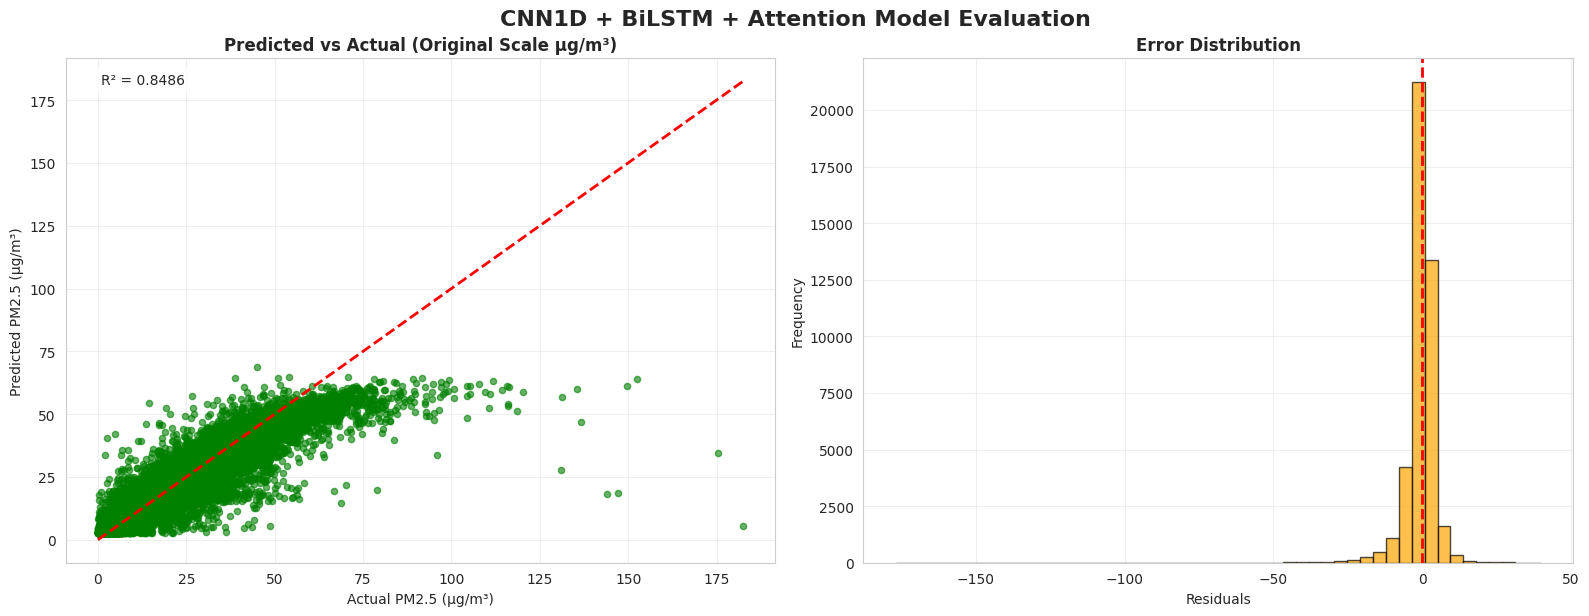


MODEL PERFORMANCE SUMMARY

[ARCHITECTURE] Model Architecture:
   • CNN1D layers: [64, 128, 256]
   • BiLSTM units: 128
   • Self-Attention: SeqSelfAttention with ELU activation
   • Total parameters: 1,023,105

[TRAINING] Training Details:
   • Training samples: 201,482
   • Validation samples: 42,725
   • Test samples: 42,934
   • Sequence length: 24
   • Features: 18

[PERFORMANCE] Model Performance on Test Set:

[METRICS] CNN1D-BiLSTM-Attention Performance:
------------------------------------------------------------
   R²:   0.848607   (Coefficient of Determination)
   RMSE: 5.053145   (Root Mean Square Error)
   MAE:  2.901412   (Mean Absolute Error)
   MSE:  25.534270   (Mean Squared Error)
   MAPE: 28.0642%   (Mean Absolute Percentage Error)
------------------------------------------------------------

[LOSS] Final Training Loss: 0.001750
[LOSS] Final Validation Loss: 0.001434

[ERROR STATS] Residual Statistics:
   Mean Error: -0.5136 μg/m³
   Std Error: 5.0270 μg/m³
   Max Abs

In [20]:
# Create comprehensive evaluation plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Prediction vs Actual (Original Scale)
axes[0].scatter(y_test_original, y_test_pred_original, alpha=0.6, s=20, color='green')
axes[0].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0].set_title('Predicted vs Actual (Original Scale μg/m³)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
r2_orig = r2_score(y_test_original, y_test_pred_original)
axes[0].text(0.05, 0.95, f'R² = {r2_orig:.4f}', transform=axes[0].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Error Distribution
residuals = y_test_pred_original - y_test_original
axes[1].hist(residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('CNN1D + BiLSTM + Attention Model Evaluation', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print detailed performance summary
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\n[ARCHITECTURE] Model Architecture:")
print(f"   • CNN1D layers: {MODEL_PARAMS['cnn_filters']}")
print(f"   • BiLSTM units: {MODEL_PARAMS['lstm_units']}")
print(f"   • Self-Attention: SeqSelfAttention with ELU activation")
print(f"   • Total parameters: {model.count_params():,}")

print(f"\n[TRAINING] Training Details:")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"   • Validation samples: {X_val.shape[0]:,}")
print(f"   • Test samples: {X_test.shape[0]:,}")
print(f"   • Sequence length: {X_train.shape[1]}")
print(f"   • Features: {X_train.shape[2]}")

print(f"\n[PERFORMANCE] Model Performance on Test Set:")
test_metrics = calculate_metrics_safe(y_test_original, y_test_pred_original, "CNN1D-BiLSTM-Attention")

print(f"\n[LOSS] Final Training Loss: {history.history['loss'][-1]:.6f}")
print(f"[LOSS] Final Validation Loss: {history.history['val_loss'][-1]:.6f}")

# Display error statistics
print(f"\n[ERROR STATS] Residual Statistics:")
print(f"   Mean Error: {residuals.mean():.4f} μg/m³")
print(f"   Std Error: {residuals.std():.4f} μg/m³")
print(f"   Max Absolute Error: {np.abs(residuals).max():.4f} μg/m³")

## 6. Time Series Analysis

Phân tích dự đoán theo chuỗi thời gian để đánh giá khả năng theo dõi xu hướng

[VISUALIZE] Creating time series prediction plots...
   Test period: 2022-11-28T13:00:00.000000000 to 2025-09-30T16:00:00.000000000
   Locations: 14 locations
   Available locations: ['7727' '7737' '233335' '7735' '7732' '7740' '7742' '7730' '7734' '7733'
 '7736' '233336' '7728' '7739']


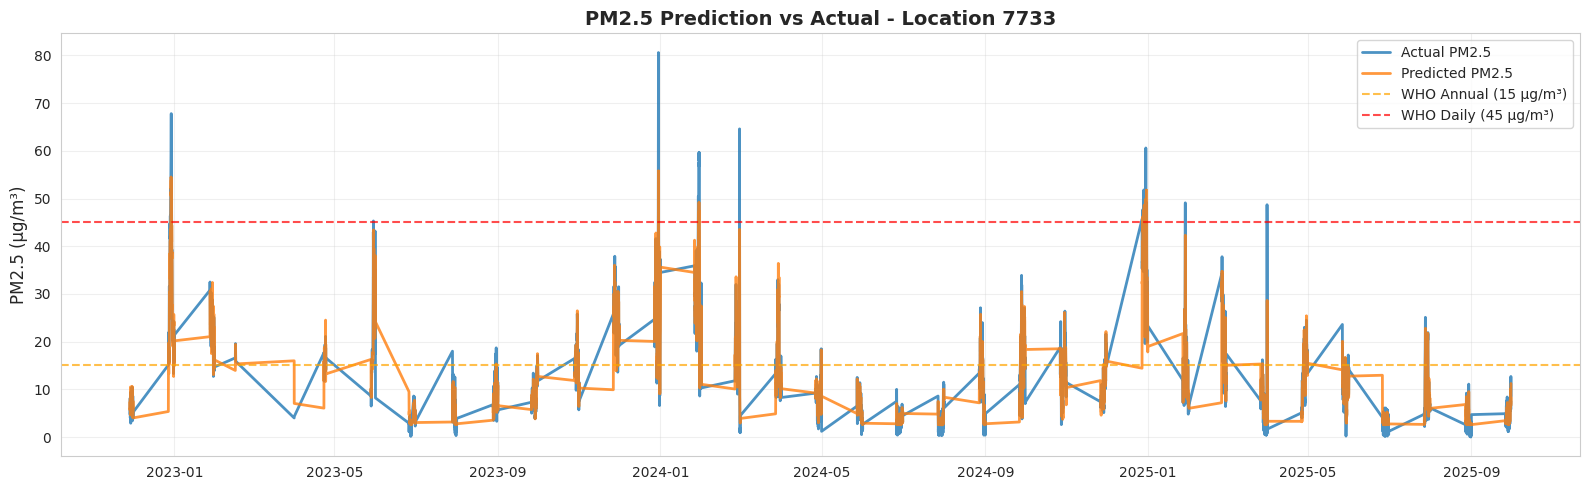


[LOCATION] Performance for Location 7733:
   • Samples: 3075
   • RMSE: 3.61 μg/m³
   • MAE:  2.25 μg/m³
   • R²:   0.9018


In [21]:
# Time series visualization using test data
print("[VISUALIZE] Creating time series prediction plots...")

# Get datetime information from test set
test_dates = cnn_test['datetime'].values
test_locations = cnn_test['location_id'].unique()

print(f"   Test period: {test_dates.min()} to {test_dates.max()}")
print(f"   Locations: {len(test_locations)} locations")
print(f"   Available locations: {test_locations}")

# Select a representative location for detailed visualization
sample_location = '7733'
location_mask = cnn_test['location_id'] == sample_location
location_indices = np.where(location_mask)[0]

if len(location_indices) > 0:
    # Extract data for selected location
    location_dates = cnn_test.loc[location_mask, 'datetime'].values
    location_actual = y_test_original[location_indices]
    location_pred = y_test_pred_original[location_indices]
    
    # Create detailed time series plot
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    
    # Plot 1: Full time series
    axes.plot(location_dates, location_actual, label='Actual PM2.5', linewidth=2, alpha=0.8)
    axes.plot(location_dates, location_pred, label='Predicted PM2.5', linewidth=2, alpha=0.8)
    axes.set_ylabel('PM2.5 (μg/m³)', fontsize=12)
    axes.set_title(f'PM2.5 Prediction vs Actual - Location {sample_location}', fontsize=14, fontweight='bold')
    axes.legend(fontsize=12)
    axes.grid(True, alpha=0.3)
    
    # Add WHO air quality guidelines
    axes.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='WHO Annual (15 μg/m³)')
    axes.axhline(y=45, color='red', linestyle='--', alpha=0.7, label='WHO Daily (45 μg/m³)')
    axes.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics for this specific location
    location_mse = mean_squared_error(location_actual, location_pred)
    location_mae = mean_absolute_error(location_actual, location_pred)
    location_r2 = r2_score(location_actual, location_pred)
    
    print(f"\n[LOCATION] Performance for Location {sample_location}:")
    print(f"   • Samples: {len(location_actual)}")
    print(f"   • RMSE: {np.sqrt(location_mse):.2f} μg/m³")
    print(f"   • MAE:  {location_mae:.2f} μg/m³")
    print(f"   • R²:   {location_r2:.4f}")
    
else:
    print("[WARNING] No data found for selected location")

[COMPARE] Multi-location performance comparison...


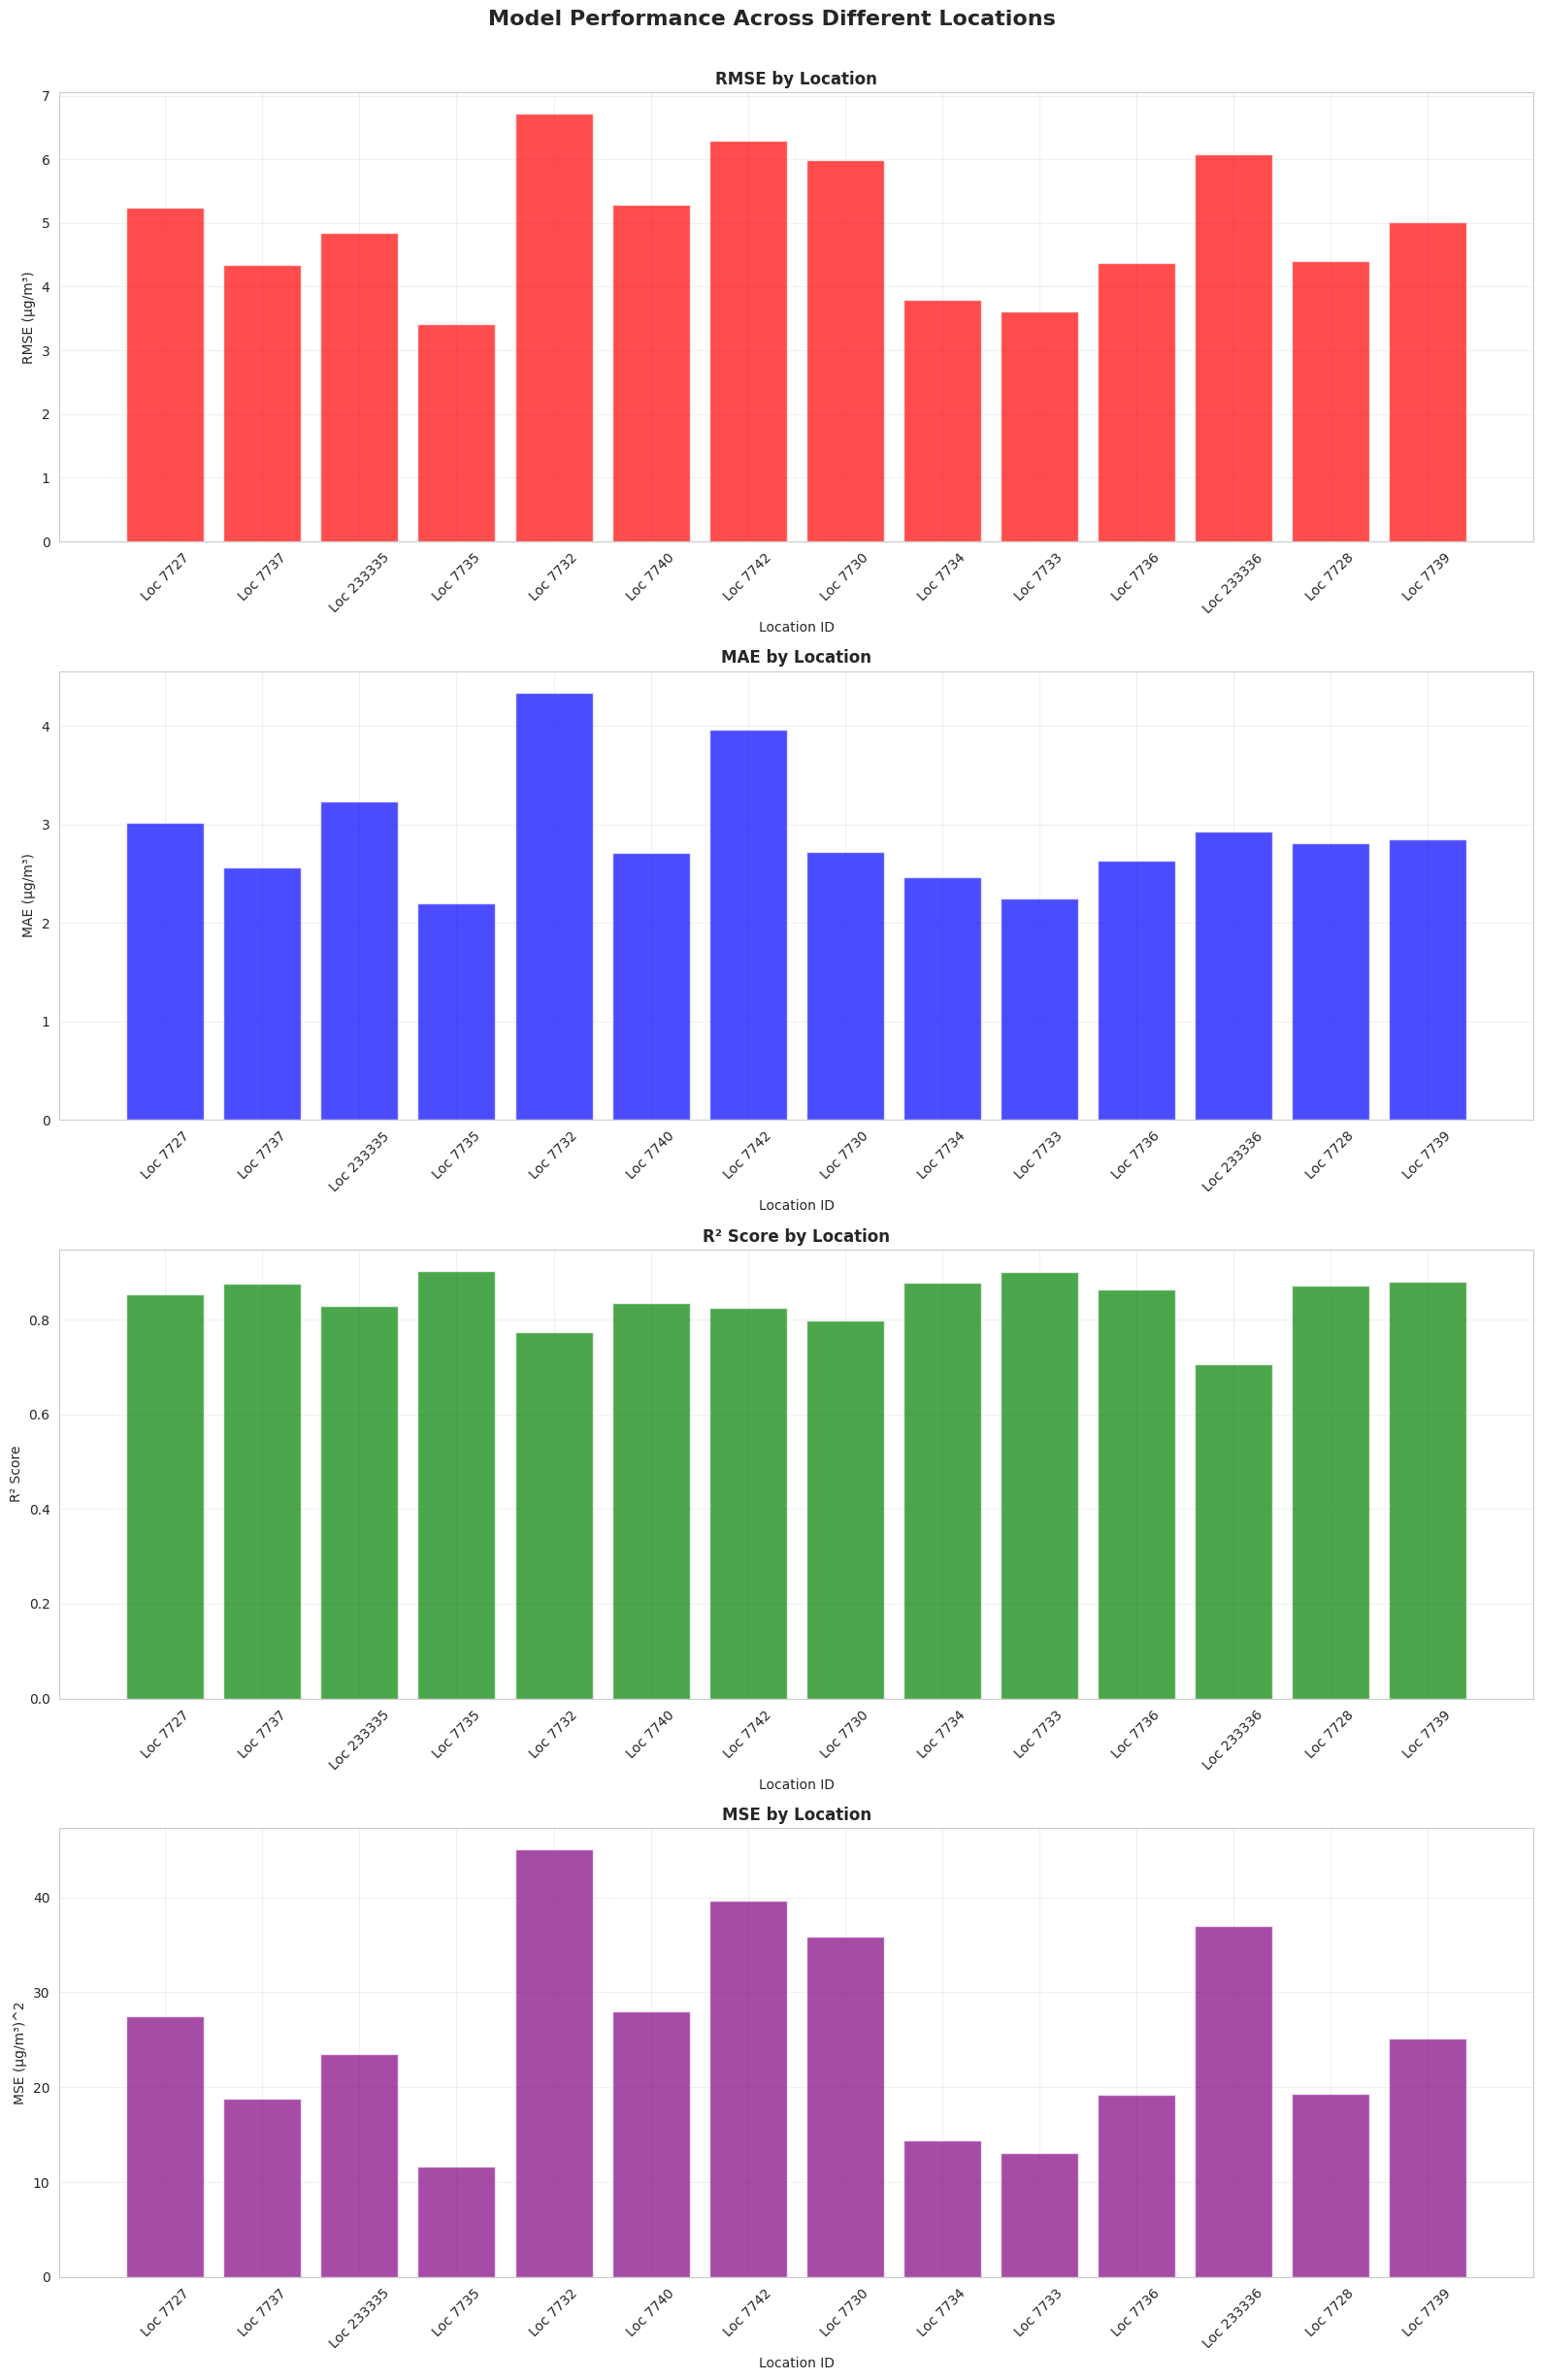


[PERFORMANCE] Location-specific performance:
----------------------------------------------------------------------
Location   Samples  RMSE       MAE        R²      
----------------------------------------------------------------------
7727       3136     5.24       3.01       0.8537  
7737       3085     4.34       2.57       0.8765  
233335     2905     4.85       3.23       0.8297  
7735       3118     3.41       2.20       0.9032  
7732       3109     6.71       4.34       0.7747  
7740       3112     5.29       2.71       0.8359  
7742       2941     6.30       3.96       0.8254  
7730       3017     5.99       2.72       0.7976  
7734       3035     3.80       2.46       0.8780  
7733       3075     3.61       2.25       0.9018  
7736       3097     4.38       2.64       0.8638  
233336     3059     6.08       2.93       0.7059  
7728       3118     4.40       2.81       0.8729  
7739       3127     5.01       2.85       0.8799  
-----------------------------------------------

In [22]:
# Multi-location comparison
print("[COMPARE] Multi-location performance comparison...")

# Calculate metrics for each location
location_performance = {}

for loc in test_locations:
    loc_mask = cnn_test['location_id'] == loc
    loc_indices = np.where(loc_mask)[0]
    
    if len(loc_indices) > 10:  # Only include locations with sufficient data
        loc_actual = y_test_original[loc_indices]
        loc_pred = y_test_pred_original[loc_indices]
        
        location_performance[loc] = {
            'samples': len(loc_actual),
            'rmse': np.sqrt(mean_squared_error(loc_actual, loc_pred)),
            'mae': mean_absolute_error(loc_actual, loc_pred),
            'r2': r2_score(loc_actual, loc_pred),
            'mse': mean_squared_error(loc_actual, loc_pred)
        }

# Create performance comparison plot
if location_performance:
    locations = list(location_performance.keys())
    rmse_values = [location_performance[loc]['rmse'] for loc in locations]
    mae_values = [location_performance[loc]['mae'] for loc in locations]
    r2_values = [location_performance[loc]['r2'] for loc in locations]
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 24))
    
    # RMSE comparison
    axes[0].bar(range(len(locations)), rmse_values, alpha=0.7, color='red')
    axes[0].set_xlabel('Location ID')
    axes[0].set_ylabel('RMSE (μg/m³)')
    axes[0].set_title('RMSE by Location', fontweight='bold')
    axes[0].set_xticks(range(len(locations)))
    axes[0].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # MAE comparison
    axes[1].bar(range(len(locations)), mae_values, alpha=0.7, color='blue')
    axes[1].set_xlabel('Location ID')
    axes[1].set_ylabel('MAE (μg/m³)')
    axes[1].set_title('MAE by Location', fontweight='bold')
    axes[1].set_xticks(range(len(locations)))
    axes[1].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # R² comparison
    axes[2].bar(range(len(locations)), r2_values, alpha=0.7, color='green')
    axes[2].set_xlabel('Location ID')
    axes[2].set_ylabel('R² Score')
    axes[2].set_title('R² Score by Location', fontweight='bold')
    axes[2].set_xticks(range(len(locations)))
    axes[2].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[2].grid(True, alpha=0.3)

    # MSE comparison
    axes[3].bar(range(len(locations)), [location_performance[loc]['mse'] for loc in locations], alpha=0.7, color='purple')
    axes[3].set_xlabel('Location ID')
    axes[3].set_ylabel('MSE (μg/m³)^2')
    axes[3].set_title('MSE by Location', fontweight='bold')
    axes[3].set_xticks(range(len(locations)))
    axes[3].set_xticklabels([f'Loc {loc}' for loc in locations], rotation=45)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Model Performance Across Different Locations', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print location-specific performance
    print(f"\n[PERFORMANCE] Location-specific performance:")
    print("-" * 70)
    print(f"{'Location':<10} {'Samples':<8} {'RMSE':<10} {'MAE':<10} {'R²':<8}")
    print("-" * 70)
    
    for loc in locations:
        perf = location_performance[loc]
        print(f"{loc:<10} {perf['samples']:<8} {perf['rmse']:<10.2f} {perf['mae']:<10.2f} {perf['r2']:<8.4f}")
    
    # Overall statistics
    overall_rmse = np.mean(rmse_values)
    overall_mae = np.mean(mae_values)
    overall_r2 = np.mean(r2_values)
    
    print("-" * 70)
    print(f"{'Average':<10} {'':<8} {overall_rmse:<10.2f} {overall_mae:<10.2f} {overall_r2:<8.4f}")
    print(f"{'Std Dev':<10} {'':<8} {np.std(rmse_values):<10.2f} {np.std(mae_values):<10.2f} {np.std(r2_values):<8.4f}")

## 7. Model Saving & Results Summary

Lưu mô hình và tạo báo cáo tổng kết kết quả

In [23]:
# Save model and results
print("[SAVE] Saving model and results...")

# Save trained model
model_save_path = "cnn_bilstm_attention_pm25_model.keras"
model.save(model_save_path)
print(f"[SUCCESS] Model saved to: {model_save_path}")

# Prepare results summary
results_summary = {
    "model_name": "CNN1D_BiLSTM_Attention",
    "model_architecture": {
        "cnn_filters": MODEL_PARAMS['cnn_filters'],
        "lstm_units": MODEL_PARAMS['lstm_units'],
        "dropout_rate": MODEL_PARAMS['dropout_rate'],
        "total_parameters": int(model.count_params())
    },
    "training_config": {
        "epochs_run": len(history.history['loss']),
        "batch_size": TRAINING_CONFIG['batch_size'],
        "training_time_seconds": float(training_time),
        "best_epoch": int(np.argmin(history.history['val_loss']) + 1)
    },
    "dataset_info": {
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test),
        "sequence_length": int(X_train.shape[1]),
        "features_per_timestep": int(X_train.shape[2]),
        "locations_count": len(test_locations)
    },
    "performance_metrics": {
        "normalized_scale": {
            "train_rmse": float(np.sqrt(train_metrics['mse'])),
            "val_rmse": float(np.sqrt(val_metrics['mse'])),
            "test_rmse": float(np.sqrt(test_metrics['mse'])),
            "test_r2": float(test_metrics['r2'])
        },
        "original_scale_ugm3": {
            "test_rmse": float(original_metrics['rmse']),
            "test_mae": float(original_metrics['mae']),
            "test_mape": float(original_metrics['mape']) if original_metrics['mape'] is not None else None,
            "test_r2": float(original_metrics['r2'])
        }
    },
    "data_ranges": {
        "actual_pm25_range": [float(y_test_original.min()), float(y_test_original.max())],
        "predicted_pm25_range": [float(y_test_pred_original.min()), float(y_test_pred_original.max())]
    }
}

# Save results to JSON
results_path = "cnn_bilstm_attention_results.json"
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"[SUCCESS] Results saved to: {results_path}")

# Create final summary report
print("\n" + "="*90)
print("FINAL MODEL EVALUATION REPORT")
print("="*90)

print(f"\n[MODEL] CNN1D + BiLSTM + Self-Attention for PM2.5 Prediction")
print(f"   Architecture: {MODEL_PARAMS['cnn_filters']} → BiLSTM({MODEL_PARAMS['lstm_units']}) → Attention → Dense")
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Training Time: {training_time:.1f}s ({training_time/60:.2f} minutes)")

print(f"\n[DATASET] Dataset Characteristics:")
print(f"   • Total samples: {len(X_train) + len(X_val) + len(X_test):,}")
print(f"   • Sequence length: {X_train.shape[1]} timesteps (24h lookback)")
print(f"   • Features per timestep: {X_train.shape[2]} (PM10, NO2, SO2, weather, time)")
print(f"   • Locations: {len(test_locations)}")
print(f"   • PM2.5 range: {y_test_original.min():.1f} - {y_test_original.max():.1f} μg/m³")

print(f"\n[PERFORMANCE] Test Set Performance (μg/m³):")
print(f"   ✓ RMSE: {original_metrics['rmse']:.2f} μg/m³")
print(f"   ✓ MAE:  {original_metrics['mae']:.2f} μg/m³")
if original_metrics['mape'] is not None:
    print(f"   ✓ MAPE: {original_metrics['mape']:.2f}%")
print(f"   ✓ R²:   {original_metrics['r2']:.4f}")
print(f"   ✓ MSE:  {original_metrics['mse']:.2f} (μg/m³)²")

print(f"\n[QUALITY] Model Quality Assessment:")
if original_metrics['r2'] > 0.8:
    print(f"   Excellent prediction accuracy (R² > 0.8)")
elif original_metrics['r2'] > 0.6:
    print(f"   Good prediction accuracy (R² > 0.6)")
else:
    print(f"   Fair prediction accuracy (R² ≤ 0.6)")
if original_metrics['mape'] is not None:
    if original_metrics['mape'] < 15:
        print(f"   Low prediction error (MAPE < 15%)")
    elif original_metrics['mape'] < 25:
        print(f"   Moderate prediction error (MAPE < 25%)")
    else:
        print(f"   High prediction error (MAPE ≥ 25%)")

print(f"\n[COMPARISON] WHO Air Quality Guidelines:")
who_annual = 15  # WHO annual guideline
who_daily = 45   # WHO daily guideline
print(f"   • WHO Annual Guideline: {who_annual} μg/m³")
print(f"   • WHO Daily Guideline: {who_daily} μg/m³")
print(f"   • Model RMSE: {original_metrics['rmse']:.2f} μg/m³ ({original_metrics['rmse']/who_annual*100:.1f}% of annual guideline)")

print(f"\n[SUCCESS] Model training and evaluation completed successfully!")
print(f"   Model saved: {model_save_path}")
print(f"   Results saved: {results_path}")

print("="*90)

[SAVE] Saving model and results...
[SUCCESS] Model saved to: cnn_bilstm_attention_pm25_model.keras
[SUCCESS] Results saved to: cnn_bilstm_attention_results.json

FINAL MODEL EVALUATION REPORT

[MODEL] CNN1D + BiLSTM + Self-Attention for PM2.5 Prediction
   Architecture: [64, 128, 256] → BiLSTM(128) → Attention → Dense
   Total Parameters: 1,023,105
   Training Time: 1576.0s (26.27 minutes)

[DATASET] Dataset Characteristics:
   • Total samples: 287,141
   • Sequence length: 24 timesteps (24h lookback)
   • Features per timestep: 18 (PM10, NO2, SO2, weather, time)
   • Locations: 14
   • PM2.5 range: 0.0 - 182.5 μg/m³

[PERFORMANCE] Test Set Performance (μg/m³):
   ✓ RMSE: 5.05 μg/m³
   ✓ MAE:  2.90 μg/m³
   ✓ MAPE: 28.06%
   ✓ R²:   0.8486
   ✓ MSE:  25.53 (μg/m³)²

[QUALITY] Model Quality Assessment:
   Excellent prediction accuracy (R² > 0.8)
   High prediction error (MAPE ≥ 25%)

[COMPARISON] WHO Air Quality Guidelines:
   • WHO Annual Guideline: 15 μg/m³
   • WHO Daily Guideline: 4